<a href="https://colab.research.google.com/github/sergioGarcia91/ML_and_EDA/blob/main/06a_TREs_KNeighborsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K Neighbors Classifier - Dataset: Datos de resistividad electrica TREs

> *Ser tan rápidos como el más lento, \
> y ser tan lentos como el más rápido.*

**Autor:** Sergio Andrés García Arias  
**Versión 01:** Enero 2024

# Introducción

En este Notebook utilizaremos el algoritmo `K Neighbors Classifier`, un algoritmo popular para la clasificación en aprendizaje supervisado. Este algoritmo considera un vecindario de `k` vecinos para proceder con la clasificación de un nuevo elemento.

> **Observación:** Aunque nos centraremos específicamente en el uso del `K Neighbors Classifier` en este Notebook, se recomienda realizar un Análisis Exploratorio de Datos (EDA) por separado. En un próximo Notebook, realizaremos un EDA para proporcionar una visión más completa y comprensiva del conjunto de datos.

## ¿Cómo funciona?

El `K Neighbors Classifier` clasifica un punto de datos basándose en las etiquetas de sus vecinos más cercanos. La `k` en el nombre se refiere al número de vecinos considerados para la clasificación. Durante la predicción, el algoritmo calcula la clase más común entre los `k` vecinos más cercanos y asigna esa clase al punto de datos en cuestión.

Este método es intuitivo y se basa en la suposición de que datos similares deberían tener etiquetas similares. Visualmente, se puede imaginar como la asignación de clases en función de la mayoría de los votos en un vecindario definido por la distancia.

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/800px-KnnClassification.svg.png' width=500 />

Se desea clasificar es el `círculo verde`. Para `k = 3` este es clasificado con la clase `triángulo`, ya que hay solo un cuadrado y 2 triángulos, dentro del círculo que los contiene. Si `k = 5` este es clasificado con la clase `cuadrado`, ya que hay 2 triángulos y 3 cuadrados, dentro del círculo externo.. *Fuente: [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)*
</center>


# Inicio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.neighbors import KNeighborsClassifier # Para la clasificacion

# Cargar CSV

In [2]:
# Valores de resistividad de las TREs
url = 'https://raw.githubusercontent.com/sergioGarcia91/ML_and_EDA/main/Datasets/DatosTREs.csv'
df = pd.read_csv(url, sep=';', decimal=',')
df

,Linea,X,Y,Z,Resistivity
0,TRE01,452.94,1667.70,88.70,60.82
1,TRE01,1012.40,1457.38,19.45,9.54
2,TRE01,579.27,1620.20,24.32,14.50
3,TRE01,592.80,1615.12,23.92,14.00
4,TRE01,601.83,1611.72,23.63,13.08
...,...,...,...,...,...
4439,TRE07,165.93,81.94,35.99,17.65
4440,TRE07,528.40,362.87,34.37,7.86
4441,TRE07,513.30,351.17,34.66,9.19
4442,TRE07,207.46,114.13,35.29,16.43


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4444 entries, 0 to 4443
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Linea        4444 non-null   object 
 1   X            4444 non-null   float64
 2   Y            4444 non-null   float64
 3   Z            4444 non-null   float64
 4   Resistivity  4444 non-null   float64
dtypes: float64(4), object(1)
memory usage: 173.7+ KB


In [4]:
df.describe()

,X,Y,Z,Resistivity
count,4444.000000,4444.000000,4444.000000,4444.000000
mean,776.210079,865.376739,33.847088,13.140801
std,355.150653,490.535396,38.315403,14.414831
min,0.000000,0.000000,-65.070000,1.320000
25%,456.660000,427.020000,7.890000,7.850000
50%,809.370000,770.430000,41.425000,10.520000
75%,1024.840000,1442.325000,63.715000,14.520000
max,1505.280000,1827.330000,100.880000,460.920000


# Visualización

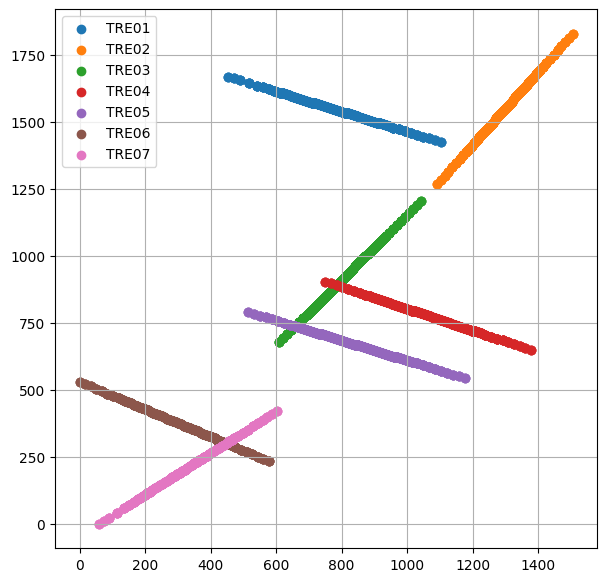

In [5]:
plt.figure(figsize=(7, 7))
for i in df['Linea'].unique():
  filtro = df['Linea'] ==  i
  plt.scatter(df['X'][filtro],
              df['Y'][filtro],
              label=i)
plt.legend()
plt.grid()
plt.show()

# Preparación Previa

Antes de proceder con el entrenamiento del modelo, es va a establecer una escala de colores predefinida para la visualización.

La escala de resistividades será utilizada para crear categorías, donde cada valor corresponderá a un límite inferior o superior en la representación cromática. Bajo este criterio, se generan un total de 17 categorías.

```python
colores = ['midnightblue', 'navy', 'darkblue', 'blue', 'royalblue', 'aqua',
          'springgreen', 'lime', 'darkgreen', 'greenyellow', 'yellow',
          'darkgoldenrod', 'orange', 'crimson', 'red', 'darkred', 'purple']

limitesRes = np.array([1, 1.35, 1.82, 2.46, 3.32, 4.48,
                       6.05, 8.17, 11.03, 14.89, 20.11,
                       27.14, 36.64, 49.47, 66.78, 90.16, 500])

categorias = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])
```

In [6]:
dfRes = df.copy()
dfRes

,Linea,X,Y,Z,Resistivity
0,TRE01,452.94,1667.70,88.70,60.82
1,TRE01,1012.40,1457.38,19.45,9.54
2,TRE01,579.27,1620.20,24.32,14.50
3,TRE01,592.80,1615.12,23.92,14.00
4,TRE01,601.83,1611.72,23.63,13.08
...,...,...,...,...,...
4439,TRE07,165.93,81.94,35.99,17.65
4440,TRE07,528.40,362.87,34.37,7.86
4441,TRE07,513.30,351.17,34.66,9.19
4442,TRE07,207.46,114.13,35.29,16.43


In [7]:
colores = ['midnightblue', 'navy', 'darkblue', 'blue', 'royalblue', 'aqua',
           'springgreen', 'lime', 'darkgreen', 'greenyellow', 'yellow',
           'darkgoldenrod', 'orange', 'crimson', 'red', 'darkred', 'purple']
limitesRes = np.array([1, 1.35, 1.82, 2.46, 3.32, 4.48,
                       6.05, 8.17, 11.03, 14.89, 20.11,
                       27.14, 36.64, 49.47, 66.78, 90.16, 500])
categorias = np.arange(len(limitesRes))
categorias

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [8]:
dfRes['Categoria'] = 0
dfRes

,Linea,X,Y,Z,Resistivity,Categoria
0,TRE01,452.94,1667.70,88.70,60.82,0
1,TRE01,1012.40,1457.38,19.45,9.54,0
2,TRE01,579.27,1620.20,24.32,14.50,0
3,TRE01,592.80,1615.12,23.92,14.00,0
4,TRE01,601.83,1611.72,23.63,13.08,0
...,...,...,...,...,...,...
4439,TRE07,165.93,81.94,35.99,17.65,0
4440,TRE07,528.40,362.87,34.37,7.86,0
4441,TRE07,513.30,351.17,34.66,9.19,0
4442,TRE07,207.46,114.13,35.29,16.43,0


In [9]:
# Establecer la etiqueta considerando los valores de resistividad eléctrica
for res in range(len(limitesRes)):

  if res == 0:
    filtro = dfRes['Resistivity'] < limitesRes[res]
    dfRes['Categoria'][filtro] = res
  else:
    filtro = (dfRes['Resistivity'] >= limitesRes[res-1]) & (dfRes['Resistivity'] < limitesRes[res])
    dfRes['Categoria'][filtro] = res

dfRes

<ipython-input-9-38b55532f77d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRes['Categoria'][filtro] = res
<ipython-input-9-38b55532f77d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRes['Categoria'][filtro] = res


,Linea,X,Y,Z,Resistivity,Categoria
0,TRE01,452.94,1667.70,88.70,60.82,14
1,TRE01,1012.40,1457.38,19.45,9.54,8
2,TRE01,579.27,1620.20,24.32,14.50,9
3,TRE01,592.80,1615.12,23.92,14.00,9
4,TRE01,601.83,1611.72,23.63,13.08,9
...,...,...,...,...,...,...
4439,TRE07,165.93,81.94,35.99,17.65,10
4440,TRE07,528.40,362.87,34.37,7.86,7
4441,TRE07,513.30,351.17,34.66,9.19,8
4442,TRE07,207.46,114.13,35.29,16.43,10


In [10]:
dfRes['Categoria'].unique()

array([14,  8,  9, 10, 11,  6,  7, 12, 13,  4,  3,  2,  5, 15, 16,  1])

# Entrenamiento

Para realizar el entrenamiento supervisado y predecir la categoría de resistividad utilizando la técnica de k vecinos más cercanos (KNN), emplearemos la clase [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) de la biblioteca `Scikit-Learn`.

Con el propósito de simplificar la configuración del modelo, nos centraremos específicamente en ajustar dos parámetros: `n_neighbors` y `weights`.

- **`n_neighbors`:** Este parámetro determina la cantidad de vecinos más cercanos que se considerarán al realizar una predicción.

- **`weights`:** Este parámetro controla cómo se ponderan las contribuciones de los vecinos en la predicción. Hay dos opciones comunes:
  - **'uniform':** Todos los vecinos tienen el mismo peso en la votación.
  - **'distance':** Los vecinos más cercanos tienen más peso que los lejanos, considerando la inversa de sus distancias. Esto puede ser beneficioso cuando algunos vecinos son más relevantes que otros.

In [11]:
X = dfRes[['X', 'Y', 'Z']].to_numpy() # Tomamos las coordenadas de los puntos
y = np.reshape(dfRes['Categoria'].to_numpy(), (-1,1)) # Las etiquetas
X

array([[ 452.94, 1667.7 ,   88.7 ],
       [1012.4 , 1457.38,   19.45],
       [ 579.27, 1620.2 ,   24.32],
       ...,
       [ 513.3 ,  351.17,   34.66],
       [ 207.46,  114.13,   35.29],
       [  60.21,    0.  ,   95.98]])

In [12]:
# Crear el modelo
modelo_KNN = KNeighborsClassifier(n_neighbors=10, # Que considere 10 vecinos
                                  weights='distance') # Darles un peso a los vecinos según la distancia

# Entrenar
modelo_KNN.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10, weights='distance')

## Predicción

In [13]:
# Toda el área
#Xmin, Xmax = 0, 1600
#Ymin, Ymax = 0, 1900
#Zmin, Zmax = -70, 110

# Una zona de interes
Xmin, Xmax = 400, 1400
Ymin, Ymax = 500, 1250
Zmin, Zmax = -70, 110

delta = 20 # Puntos cada X metros

x = np.arange(Xmin, Xmax, delta)
y = np.arange(Ymin, Ymax, delta)
z = np.arange(Zmin, Zmax, delta)

xv, yv, zv = np.meshgrid(x, y, z) # Vertices X Y Z

In [14]:
xv.shape

(38, 50, 9)

In [15]:
yv.shape

(38, 50, 9)

In [16]:
zv.shape

(38, 50, 9)

In [17]:
matrizGrid = np.concatenate((np.reshape(xv, (-1,1)),
                             np.reshape(yv, (-1,1)),
                             np.reshape(zv, (-1,1))),
                            axis=1)
matrizGrid.shape

(17100, 3)

In [18]:
matrizGrid[:10, :]

array([[400, 500, -70],
       [400, 500, -50],
       [400, 500, -30],
       [400, 500, -10],
       [400, 500,  10],
       [400, 500,  30],
       [400, 500,  50],
       [400, 500,  70],
       [400, 500,  90],
       [420, 500, -70]])

In [19]:
categoriasGrid = modelo_KNN.predict(matrizGrid)
np.unique(categoriasGrid)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [20]:
# Para establecer un límite para solo ver un rango determinado de las etiquetas
Cmin = 10
Cmax = 13
filtroColor = (categoriasGrid.flatten() >= Cmin) & (categoriasGrid.flatten() < Cmax)

fig = go.Figure(data=[go.Scatter3d(
     x=xv.flatten()[filtroColor],
     y=yv.flatten()[filtroColor],
     z=zv.flatten()[filtroColor],
     mode='markers',
     marker=dict(
         size=4,
         color=categoriasGrid.flatten()[filtroColor],
         colorscale=colores,
         cmin=0,
         cmax=16,
         opacity=0.8)
     )])

fig.add_trace(go.Scatter3d(x=dfRes['X'],
                           y=dfRes['Y'],
                           z=dfRes['Z'],
                           mode='markers',
                           marker=dict(color=dfRes['Categoria'],
                                       size=4,
                                       colorscale=colores,
                                       colorbar=dict(tickmode='array',
                                                     tickvals=categorias),
                                       opacity=1)

                           ) )

fig.update_layout(scene_aspectmode='data')
fig.show()

## IDW

Se implementará de manera sencilla la interpolación [IDW](https://en.wikipedia.org/wiki/Inverse_distance_weighting) con el objetivo de comparar los resultados obtenidos con el algoritmo de `KNN`.

> **Observación:** Es posible que ya existan bibliotecas de Python que proporcionen una implementación más robusta del algoritmo `IDW`. En esta ocasión, se optó por crear una implementación propia únicamente a modo de ejemplo para la creación de funciones.

In [21]:
# Revisar
# referencias:
# https://en.wikipedia.org/wiki/Inverse_distance_weighting
# https://gist.github.com/Majramos/5e8985adc467b80cccb0cc22d140634e
# https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

def distance(x, y, z, xi, yi, zi):
  obs = np.vstack((x, y, z)).T
  new = np.vstack((xi, yi, zi)).T

  dx = np.subtract.outer(obs[:,0], new[:,0])
  dy = np.subtract.outer(obs[:,1], new[:,1])
  dz = np.subtract.outer(obs[:,2], new[:,2])

  dist = np.sqrt( (dx)**2 + (dy)**2 + (dz)**2 )
  dist_error = 1e-12 # Por si en un mismo punto se tiene 2 muestras con diferente valor

  return dist.T + dist_error


def idw(distance, values, p=2):
  w = 1 / (distance**p)
  w_u = w*values

  ui = np.sum(w_u, axis=1) / np.sum(w, axis=1)

  return ui

Es recomendable realizar validaciones con un conjunto de datos pequeño y fácil de controlar para verificar el correcto funcionamiento del algoritmo. Además, esta práctica se lleva a cabo con el propósito de comprender mejor la interpolación IDW.

In [22]:
x = [1, 2, 2, 4, 5, 0]
y = [1, 2, 2, 4, 5, 0]
z = [1, 2, 2, 4, 5, 0]
v = [50, 99, 3, 1, 2, 999]

xi = [1, 100, 2, 0, 1.5, 1e20]
yi = [1, 100, 2, 0, 1.5, 1e20]
zi = [1, 100, 2, 0, 1.5, 1e20]

print('Promedio de v: ', np.mean(v))
idw(distance(x, y, z, xi, yi, zi), v, p=2)

Promedio de v:  192.33333333333334


array([ 50.        , 184.17179017,  51.        , 999.        ,
        82.95103815, 192.33333333])

In [23]:
x = dfRes['X'].to_numpy()
y = dfRes['Y'].to_numpy()
z = dfRes['Y'].to_numpy()
v = dfRes['Resistivity'].to_numpy()

xi = xv.flatten()
yi = yv.flatten()
zi = zv.flatten()

resIDW = idw(distance(x, y, z, xi, yi, zi), v, p=30) # 2 10 20 30 40
print('Res min', resIDW.min())
print('Res max', resIDW.max())

Res min 8.334204875259706
Res max 18.599524766150232


In [24]:
calseIDW = resIDW.copy()
print('Promedio de : resIDW', np.mean(resIDW))

for res in range(len(limitesRes)):

  if res == 0:
    filtro = calseIDW < limitesRes[res]
    calseIDW[filtro] = res
  else:
    filtro = (calseIDW >= limitesRes[res-1]) & (calseIDW < limitesRes[res])
    calseIDW[filtro] = res

calseIDW

Promedio de : resIDW 13.229377339478402


array([8., 8., 8., ..., 9., 8., 8.])

In [25]:
Cmin = 0
Cmax = 16
filtroColor = (calseIDW.flatten() >= Cmin) & (calseIDW.flatten() < Cmax)

fig = go.Figure(data=[go.Scatter3d(
     x=xv.flatten()[filtroColor],
     y=yv.flatten()[filtroColor],
     z=zv.flatten()[filtroColor],
     mode='markers',
     marker=dict(
         size=4,
         color=calseIDW.flatten()[filtroColor],
         colorscale=colores,
         cmin=0,
         cmax=16,
         opacity=0.8)
     )])

fig.add_trace(go.Scatter3d(x=dfRes['X'],
                           y=dfRes['Y'],
                           z=dfRes['Z'],
                           mode='markers',
                           marker=dict(color=dfRes['Categoria'],
                                       size=4,
                                       colorscale=colores,
                                       colorbar=dict(tickmode='array',
                                                     tickvals=categorias),
                                       cmin=0,
                                       cmax=16,
                                       opacity=1)

                           ) )

fig.update_layout(scene_aspectmode='data')
fig.show()

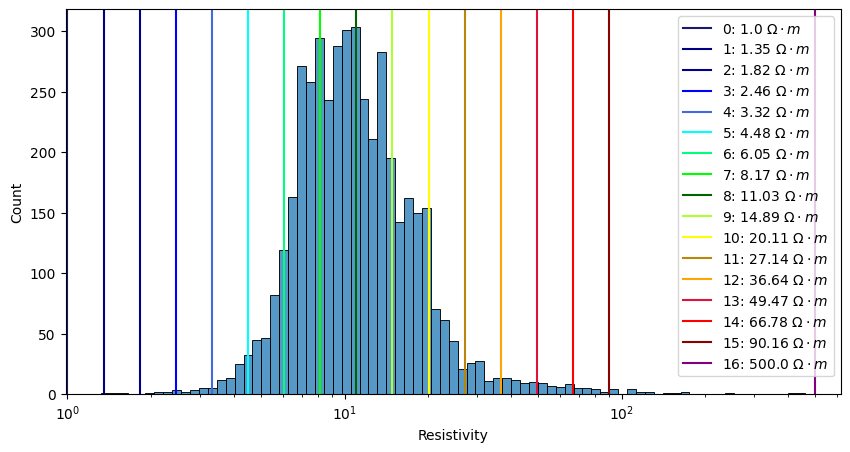

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(dfRes['Resistivity'], log_scale=True)
for i in range(len(limitesRes)):
  plt.axvline(limitesRes[i], label=f'{i}: {limitesRes[i]} $\Omega \cdot m$', c=colores[i])
plt.legend()
plt.show()

# Observaciones

Durante el uso del algoritmo `K Neighbors Classifier` y la implementación de la interpolación `IDW` en este Notebook, se pudo plantear alguna de las siguientes interrogantes:

- ¿Por qué considerar una predicción por etiquetas en lugar de valores de resistividad? ¿Cuáles son las ventajas y desventajas de esta aproximación en el contexto geológico?

- Con un conjunto de 17 etiquetas, ¿consideramos que es un número apropiado o excesivo? ¿Cómo puede afectar la cantidad de etiquetas en la capacidad del modelo para generalizar y capturar la variabilidad geológica?

- Al comparar con la interpolación IDW, surge la pregunta: ¿Sería más beneficioso utilizar un algoritmo que estime los valores de resistividad en lugar de asignar etiquetas? ¿Cómo impactaría esta elección en la calidad de las predicciones y la interpretación geológica?

- ¿Cómo podemos incorporar de manera efectiva el componente geológico en el modelo? ¿Existen características geológicas específicas que podrían mejorar la capacidad del algoritmo para identificar patrones relevantes en el subsuelo?

---
Al utilizar el `K Neighbors Classifier`, es importante tener en cuenta algunas de sus limitaciones y consideraciones:

1. **Sensibilidad a la Elección de Vecinos (K):** La elección del número de vecinos (K) puede tener un impacto significativo en el rendimiento del modelo. Es fundamental realizar pruebas con diferentes valores de K para determinar el más apropiado para el conjunto de datos específico.

2. **Dependencia de la Escala:** El algoritmo `KNN` puede ser sensible a la escala de las características. La normalización o estandarización de las variables puede ser necesaria para garantizar que todas contribuyan de manera equitativa a las predicciones.

3. **Costo Computacional:** A medida que el tamaño del conjunto de datos crece, el costo computacional de buscar vecinos cercanos puede aumentar. Evaluar la eficiencia del algoritmo en conjuntos de datos más grandes es esencial para garantizar un rendimiento aceptable.

4. **Clasificación Discreta:** KNN realiza predicciones basadas en la mayoría de votos de los vecinos más cercanos, lo que puede conducir a fronteras de decisión discretas y en forma de polígonos.

5. **Balance en el Conjunto de Datos:** Es importante considerar la distribución de las clases en el conjunto de datos. Desbalances significativos pueden afectar la capacidad del modelo para generalizar correctamente.

6. **Exploración de Hiperparámetros:** Realizar ajustes en hiperparámetros como la métrica de distancia y la función de peso puede influir en el rendimiento del modelo. Experimentar con diferentes configuraciones puede ser necesario para optimizar el desempeño.


# Fin